<a href="https://colab.research.google.com/github/byeolbyeolbyeol/Dog_Cat_Flower/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    # 여기 경로 바꿔주시고
    data_dir='./content',
    # 여기 True로 변경
    download=True,
    with_info=True,
    as_supervised=True,
)

In [27]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [30]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [31]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [32]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [33]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [35]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [36]:
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer = tf.keras.layers.Dense(units=256,
                                    activation='relu')
# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(units=5,
                                         activation='softmax')
# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 5)


In [37]:
base_model.trainable = False

In [38]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.1965 - loss: 1.6309
initial loss: 1.65
initial accuracy: 0.18


In [42]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.3173 - loss: 1.5768 - val_accuracy: 0.6294 - val_loss: 1.2982
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.6168 - loss: 1.2481 - val_accuracy: 0.7003 - val_loss: 1.0430
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7074 - loss: 1.0199 - val_accuracy: 0.7248 - val_loss: 0.8868
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7338 - loss: 0.8882 - val_accuracy: 0.7302 - val_loss: 0.8041
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7639 - loss: 0.7938 - val_accuracy: 0.7411 - val_loss: 0.7395


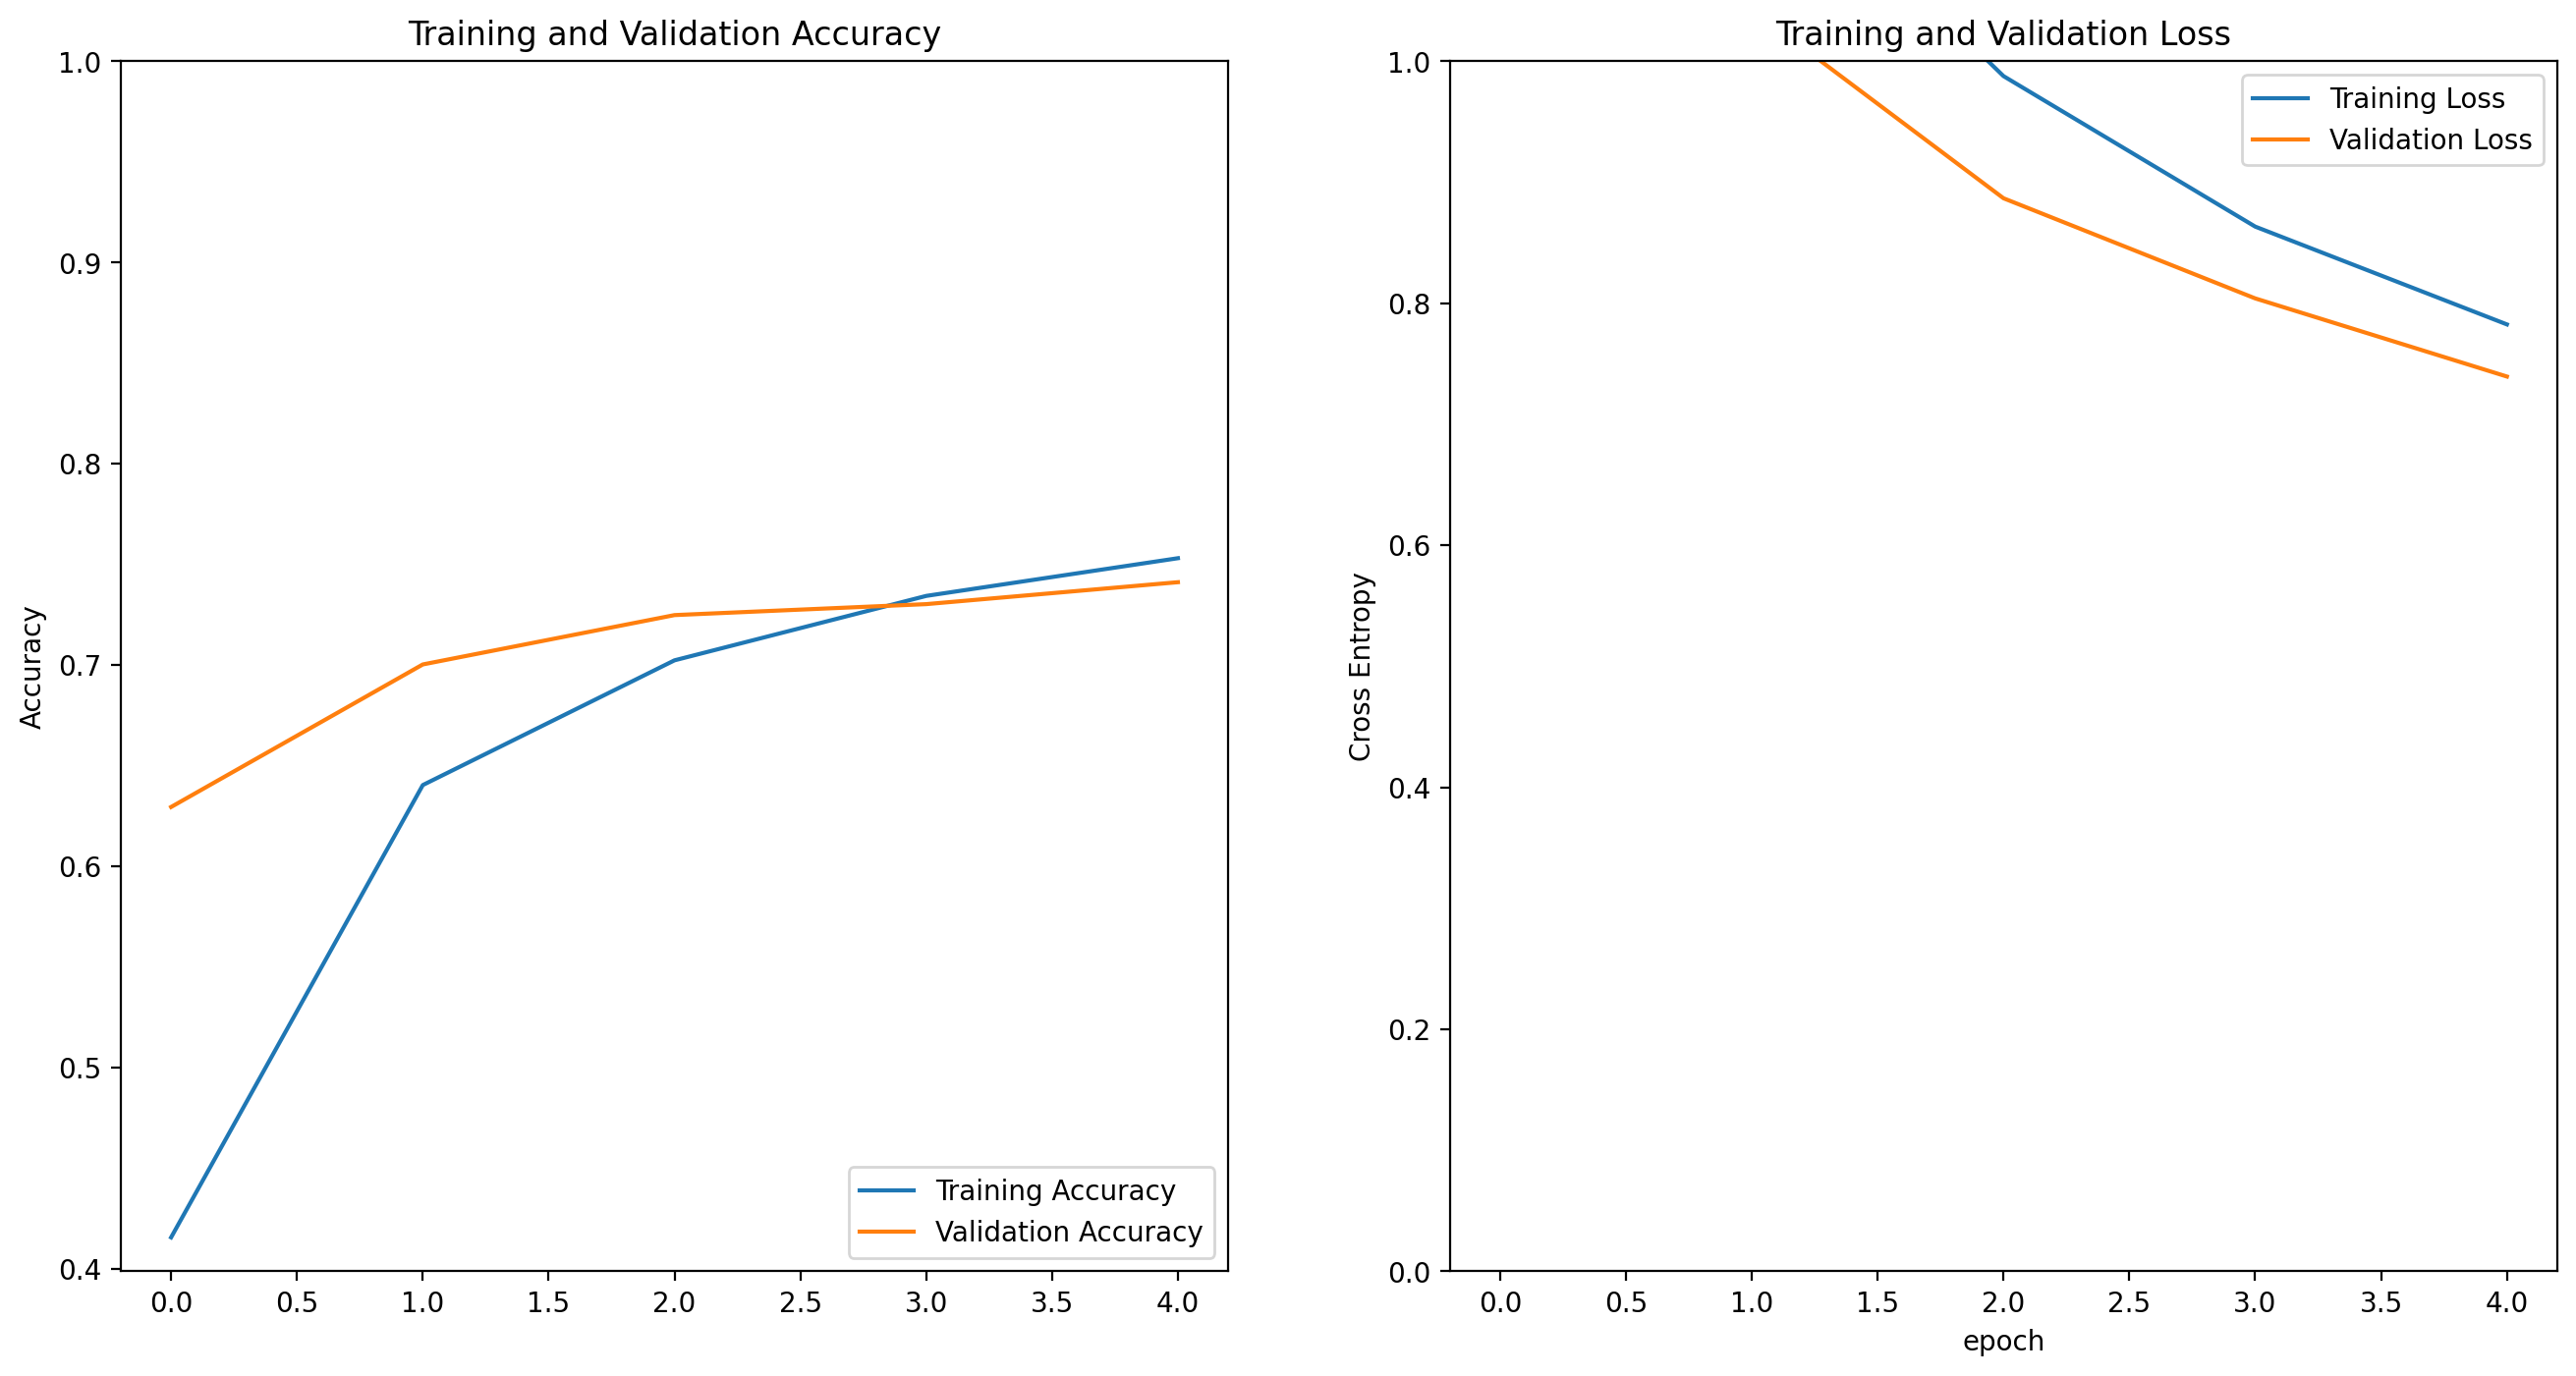

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


array([[3.92807163e-02, 8.57869387e-02, 6.15411699e-01, 1.66508242e-01,
        9.30124298e-02],
       [9.58808839e-01, 1.48019297e-02, 4.23934776e-03, 1.39218979e-02,
        8.22792575e-03],
       [6.15666628e-01, 1.28225893e-01, 5.44684976e-02, 1.46559983e-01,
        5.50789349e-02],
       [1.84773710e-02, 7.41714612e-02, 4.79864776e-01, 4.24088500e-02,
        3.85077655e-01],
       [4.92604077e-01, 2.47464046e-01, 7.84789771e-02, 6.71355277e-02,
        1.14317402e-01],
       [7.35531509e-01, 1.08600251e-01, 3.95614542e-02, 8.95183310e-02,
        2.67885029e-02],
       [5.02967462e-02, 8.19534212e-02, 4.76092666e-01, 2.48576507e-01,
        1.43080637e-01],
       [3.18598032e-01, 2.82017857e-01, 2.00760234e-02, 3.19296062e-01,
        6.00121170e-02],
       [8.25895369e-02, 3.00854053e-02, 9.53517631e-02, 6.53040349e-01,
        1.38932958e-01],
       [9.79752541e-01, 7.83986319e-03, 7.57903501e-04, 1.00274170e-02,
        1.62234239e-03],
       [8.43653262e-01, 5.9663

In [45]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 3, 3, 0, 0, 1, 3, 4, 0, 3, 2, 0, 4, 4, 2, 0,
       4, 0, 1, 4, 2, 4, 4, 3, 0, 4])

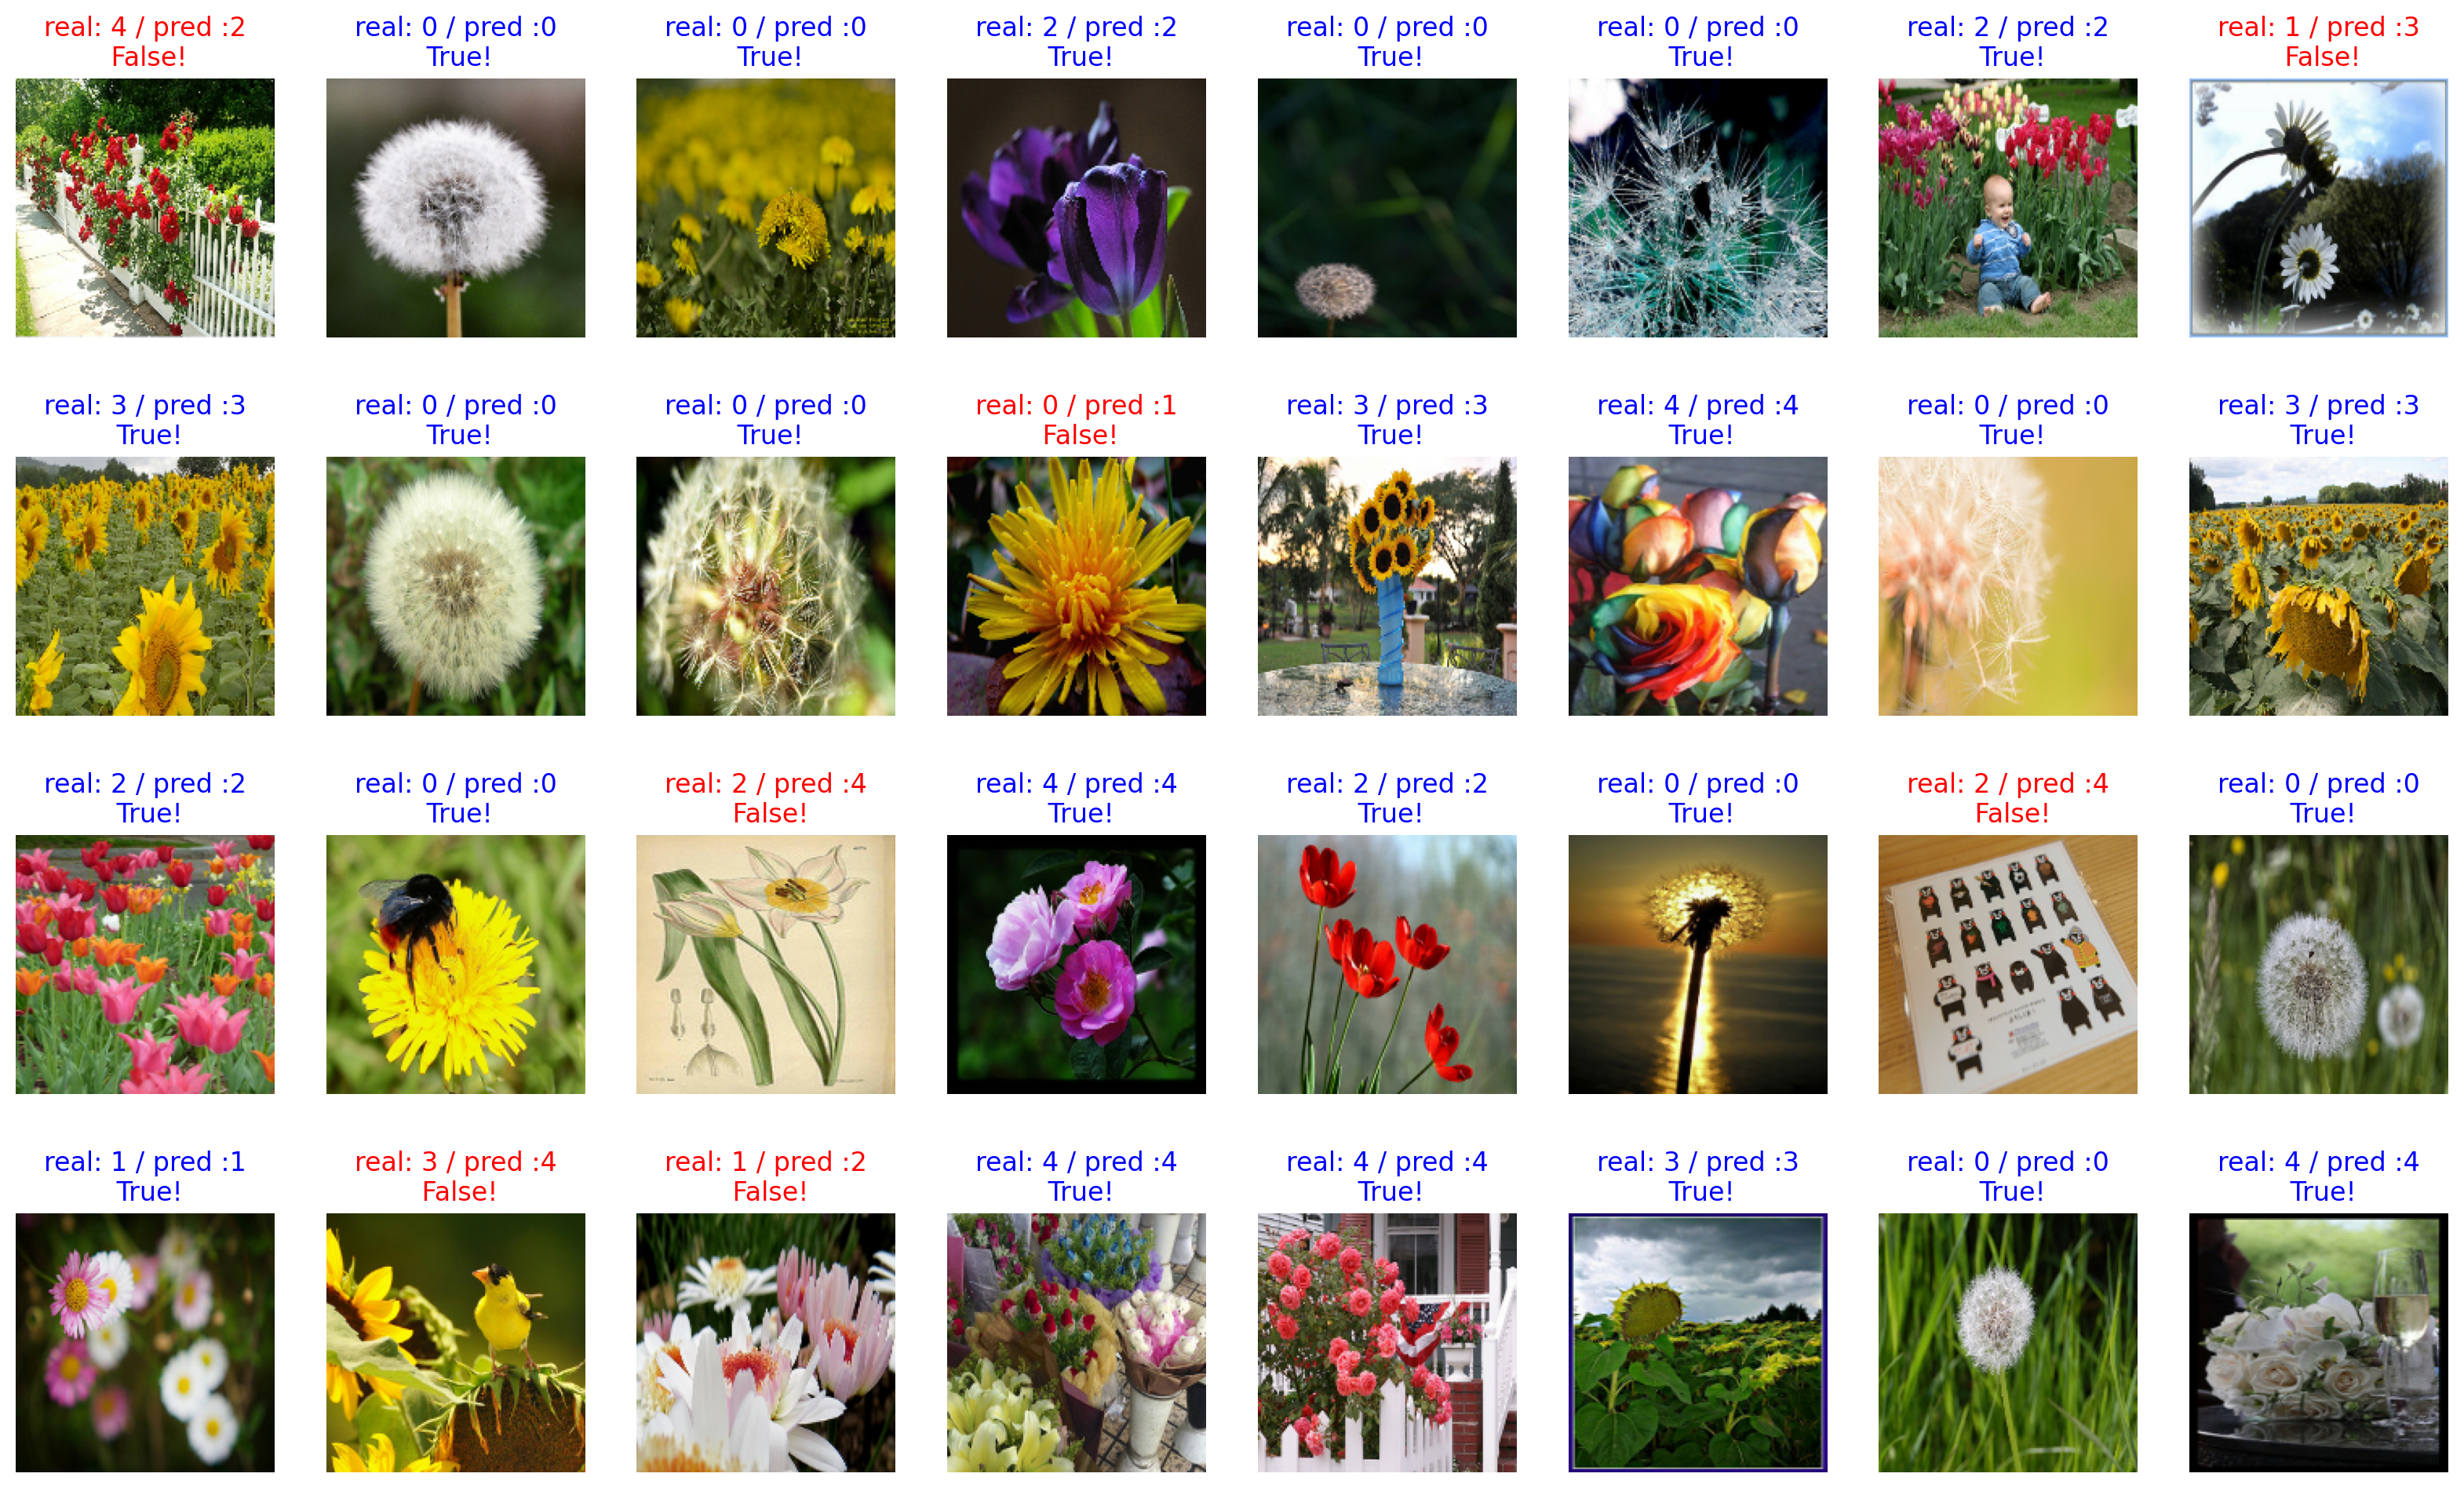

In [46]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [47]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

78.125


In [48]:
!mkdir -p ./content/checkpoint
!mkdir -p ./content/images

# 오류 리포트

최신 tensorflow에서는 가중치를 저장할때

ValueError: The filename must end in `.weights.h5`

뒤에 확장자를 바꿔줘야합니다

checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

이걸

checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint.weights.h5')

이렇게

In [49]:
import os

checkpoint_dir = "./content/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint.weights.h5')

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [50]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")